# Mugration Analysis

---
## Questions

### 1. ... Biovar...phylo branch

---
## Setup

### Module Imports

In [1]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os
import sys
import IPython
import io

import pandas as pd
import numpy as np
import math

from geopy.distance import great_circle

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches, gridspec
import seaborn as sns

### Input File Paths

In [2]:
tree_path = "../../docs/results/latest/branch_support/branch_support.xml"
tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
outdir = "../../docs/results/latest/mugration/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [3]:
# Metadata
NAME_COL = "Sample"
DATES_COL = "Date"
ATTRIBUTE_LIST = ["Branch_Major", "Branch_Minor"]
"""ATTRIBUTE_LIST = [
    "Branch_Major", 
    "Branch_Minor",
    "Country",
    "Province",
    "Biovar"
    ]"""
NO_DATA_CHAR = "NA"

# Optional, lat, lon
#ATTRIBUTE_LAT = ATTRIBUTE + "Lat"
#ATTRIBUTE_LON = ATTRIBUTE + "Lon"
#DIST_UNIT = "km"

MUG_CONF_THRESH = 0.95

### Plotting Configuration

In [4]:
# Colors
HIGH_COL = "red"
LOW_COL = "black"
TERM_COL = "grey"
THRESH_COL = "blue"
# matplotlib for rainbow
COLOR_PAL = "rainbow"
# sns for everything else (see bottom of notebook)
#COLOR_PAL = "ch:s=.25,rot=-.25"

# Graphics
figsize=(6.4,4.8)
figsize_alt=(9.6,4.8)
dpi=400

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

# Lines
plt.rc('lines', linewidth=0.5)

---
## Analysis

### Read Input Tree and Dataframe

In [5]:
tree_div = Phylo.read(tree_path, "phyloxml")
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

---
## Mugration

In [6]:
# Optional: simplify the Mictorus biovar
biovar_microtus_sub = ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]
tree_df.replace(biovar_microtus_sub, "Microtus", inplace=True)

In [7]:
mug_dict = {}

for attr in ATTRIBUTE_LIST:
    mug_dict[attr] = {}
    # Make a copy of the input tree
    mug_dict[attr]["tree_div"] = copy.deepcopy(tree_div)
    # Map the taxon name to the attribute for mugration analysis
    mug_dict[attr]["leaf_to_attr"] = {sample:str(data[attr]) for sample,data in tree_df.iterrows()
                    if data[attr]!=NO_DATA_CHAR and data[attr]}    
    # Make blank dicts for the mugration output
    mug_dict[attr]["tree_mug"] = {}
    mug_dict[attr]["letter_to_state"] = {}
    mug_dict[attr]["reverse_alphabet"] = {}
    mug_dict[attr]["unique_states"] = {}

### Run mugration to capture log

In [8]:
for attr in ATTRIBUTE_LIST:
    print("Running mugration for attribute: {}".format(attr))
    # Initialize stdout capture
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    
    # Run mugration
    mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(mug_dict[attr]["tree_div"], 
                                                                     traits=mug_dict[attr]["leaf_to_attr"], 
                                                                     missing_data=NO_DATA_CHAR,
                                                                     #missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
    mug_dict[attr]["tree_mug"] = mug
    mug_dict[attr]["letter_to_state"] = letter_to_state
    mug_dict[attr]["reverse alphabet"] = reverse_alphabet
    mug_dict[attr]["unique_states"] = sorted(letter_to_state.values())
    
    # Save stdout to file
    output = new_stdout.getvalue()
    out_path = os.path.join(outdir, "mug_{}.log".format(attr.lower())) 
    with open(out_path, "w") as file:
        file.write(output)
    # Restore stdout
    sys.stdout = old_stdout

Running mugration for attribute: Branch_Major
Running mugration for attribute: Branch_Minor


### Add mugration to dataframe

In [9]:
for attr in ATTRIBUTE_LIST:
    print(attr)
    # Initialize empty values for the new mugration attribute and its confidence
    tree_df["Mugration_" + attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    tree_df["Mugration_" + attr + "_Confidence"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]    
    
    tree_mug = mug_dict[attr]["tree_mug"].tree
    unique_states = mug_dict[attr]["unique_states"]

    # Iterate through the nodes in the tree
    for c in tree_mug.find_clades():
        # Store the name and confidence for the state with the most support
        state_max_name = mug_dict[attr]["letter_to_state"][c.cseq[0]]
        state_conf_list = c.marginal_profile[0]
        state_max_conf = max(state_conf_list)
        c.other = []

        # Store all the states and confidence values
        for state_name,state_conf in zip(unique_states, state_conf_list):
            attr_other = Phylo.PhyloXML.Other(tag=state_name, value="{:0.4f}".format(state_conf), namespace=attr)
            c.other.append(attr_other)

        # Store the Maximum assigned value
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(state_max_conf), namespace=attr + "_assign")
        c.other.append(attr_other)
    
        if c.name in tree_df.index:
            tree_df["Mugration_" + attr][c.name] = state_max_name
            tree_df["Mugration_" + attr + "_Confidence"][c.name] = state_max_conf

Branch_Major


/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Branch_Minor


---
## Plotting

### Mugration Boxplots

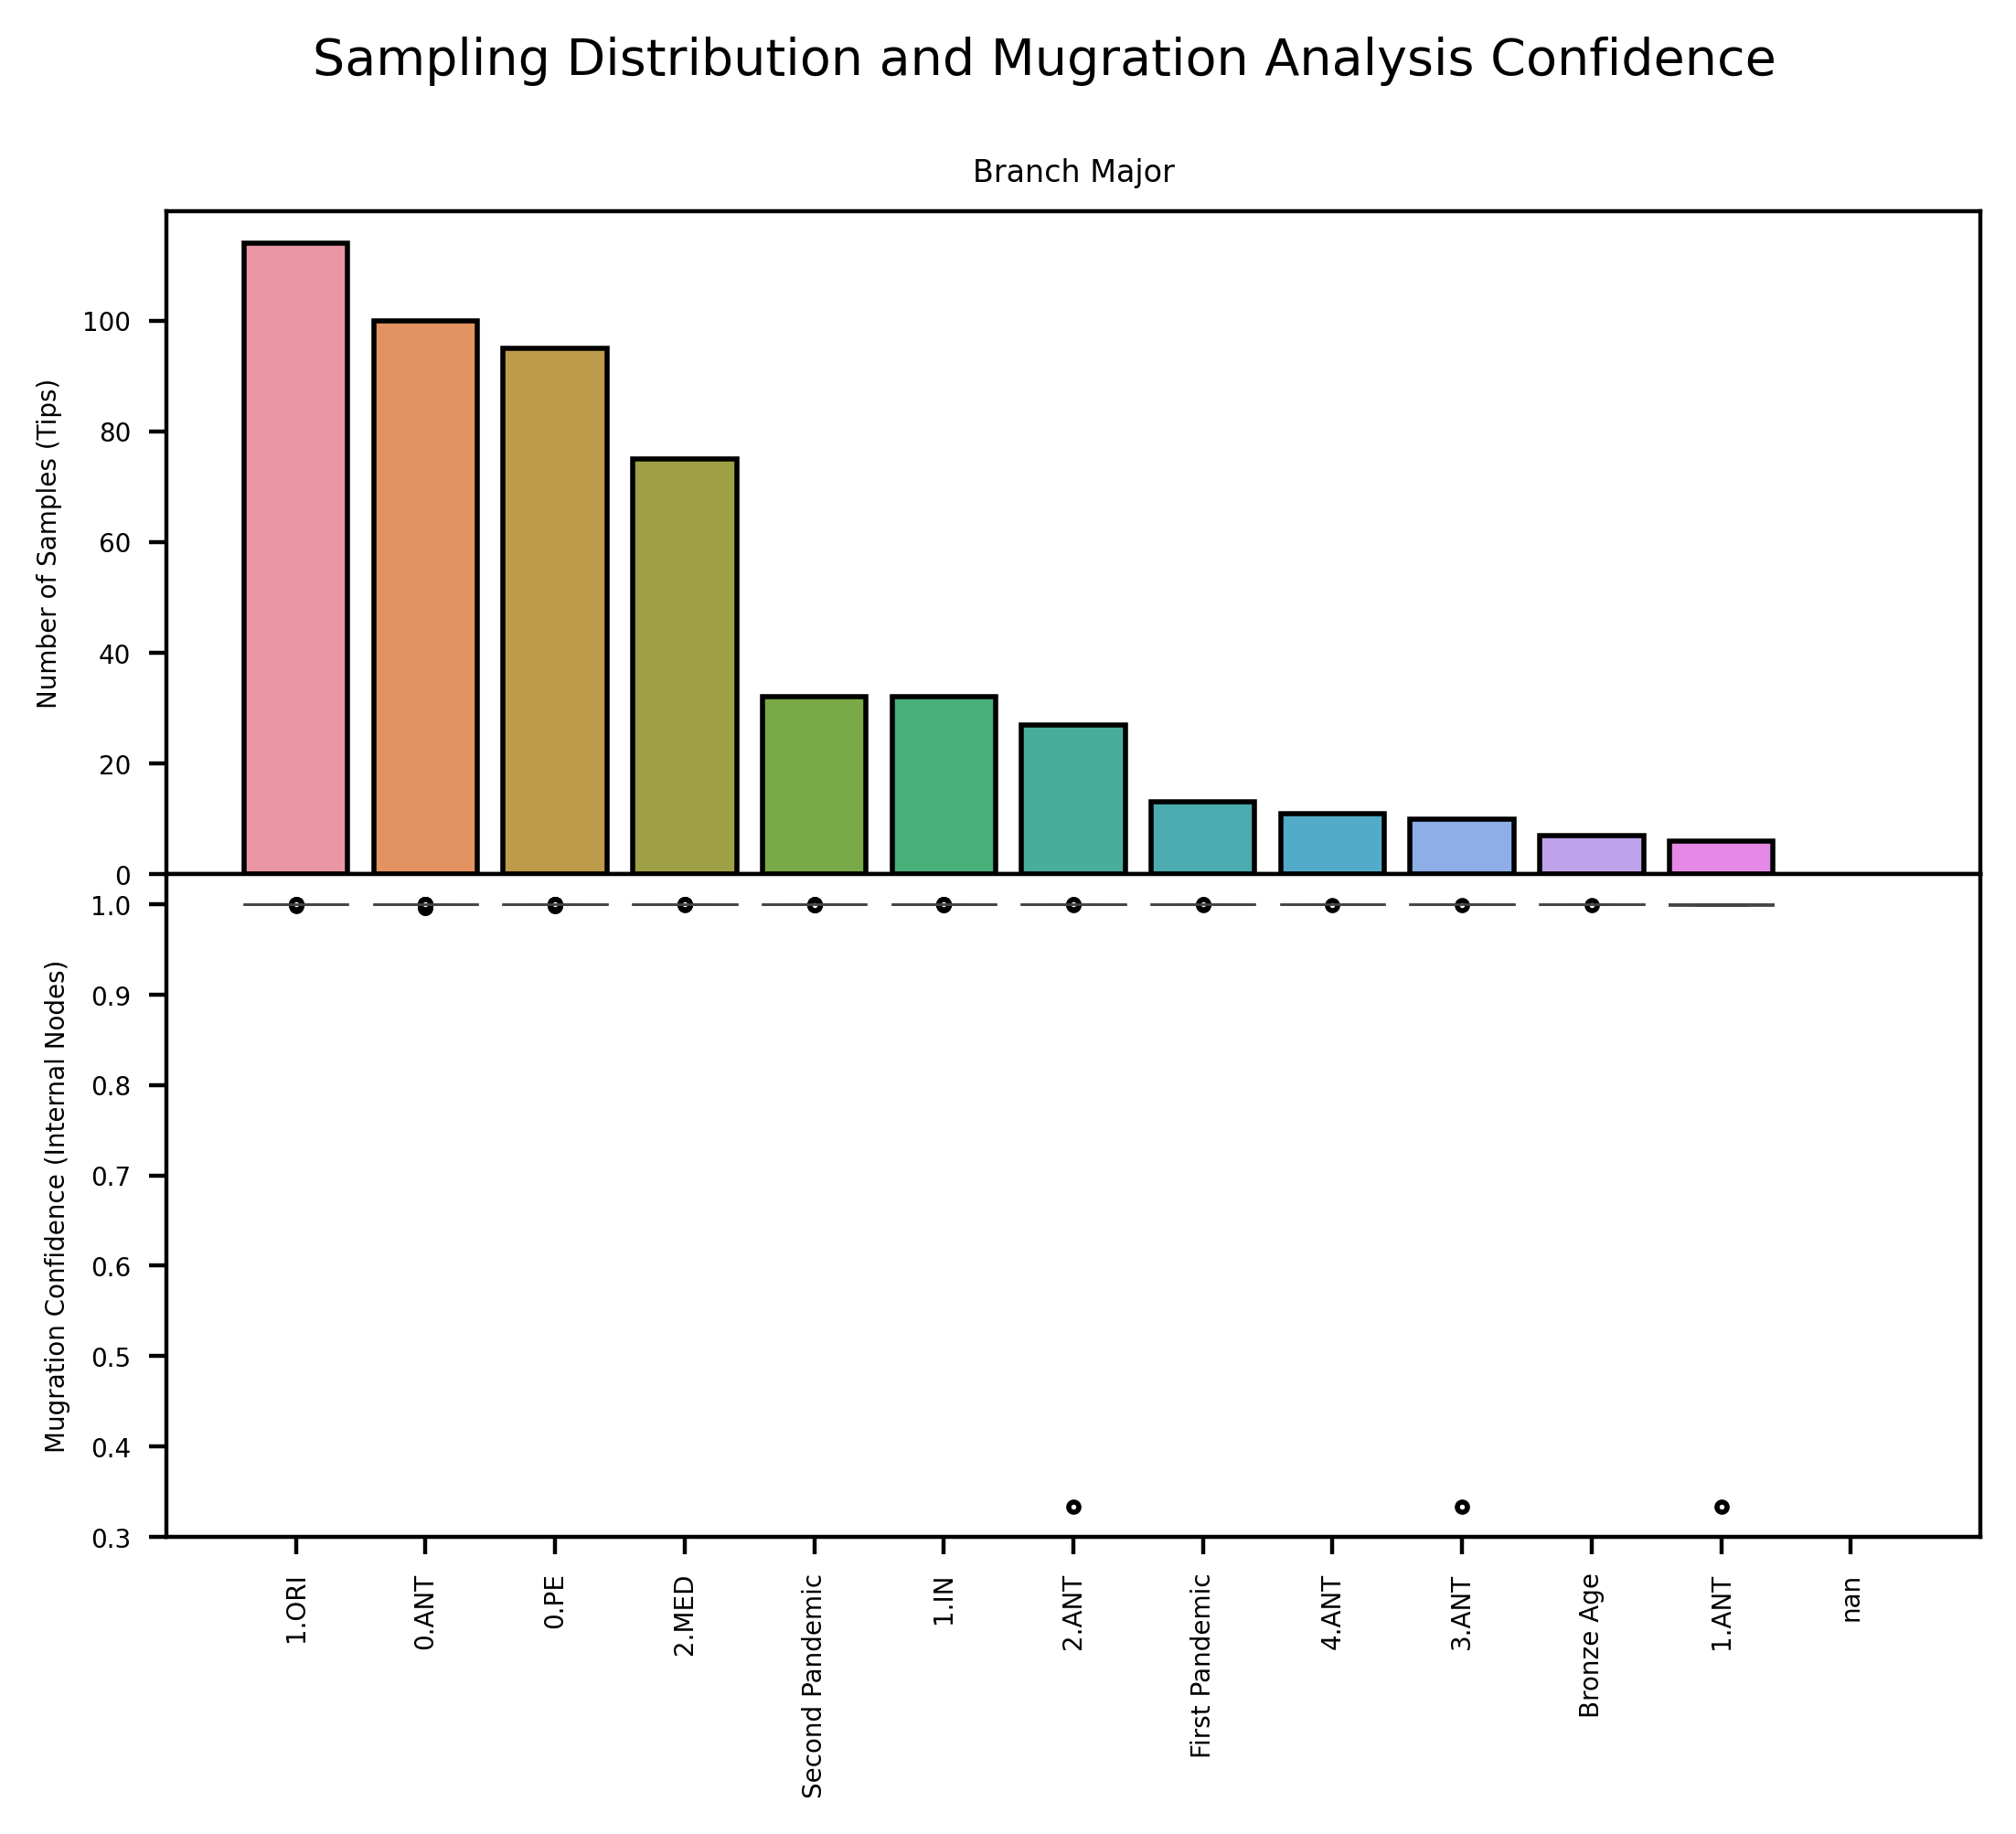

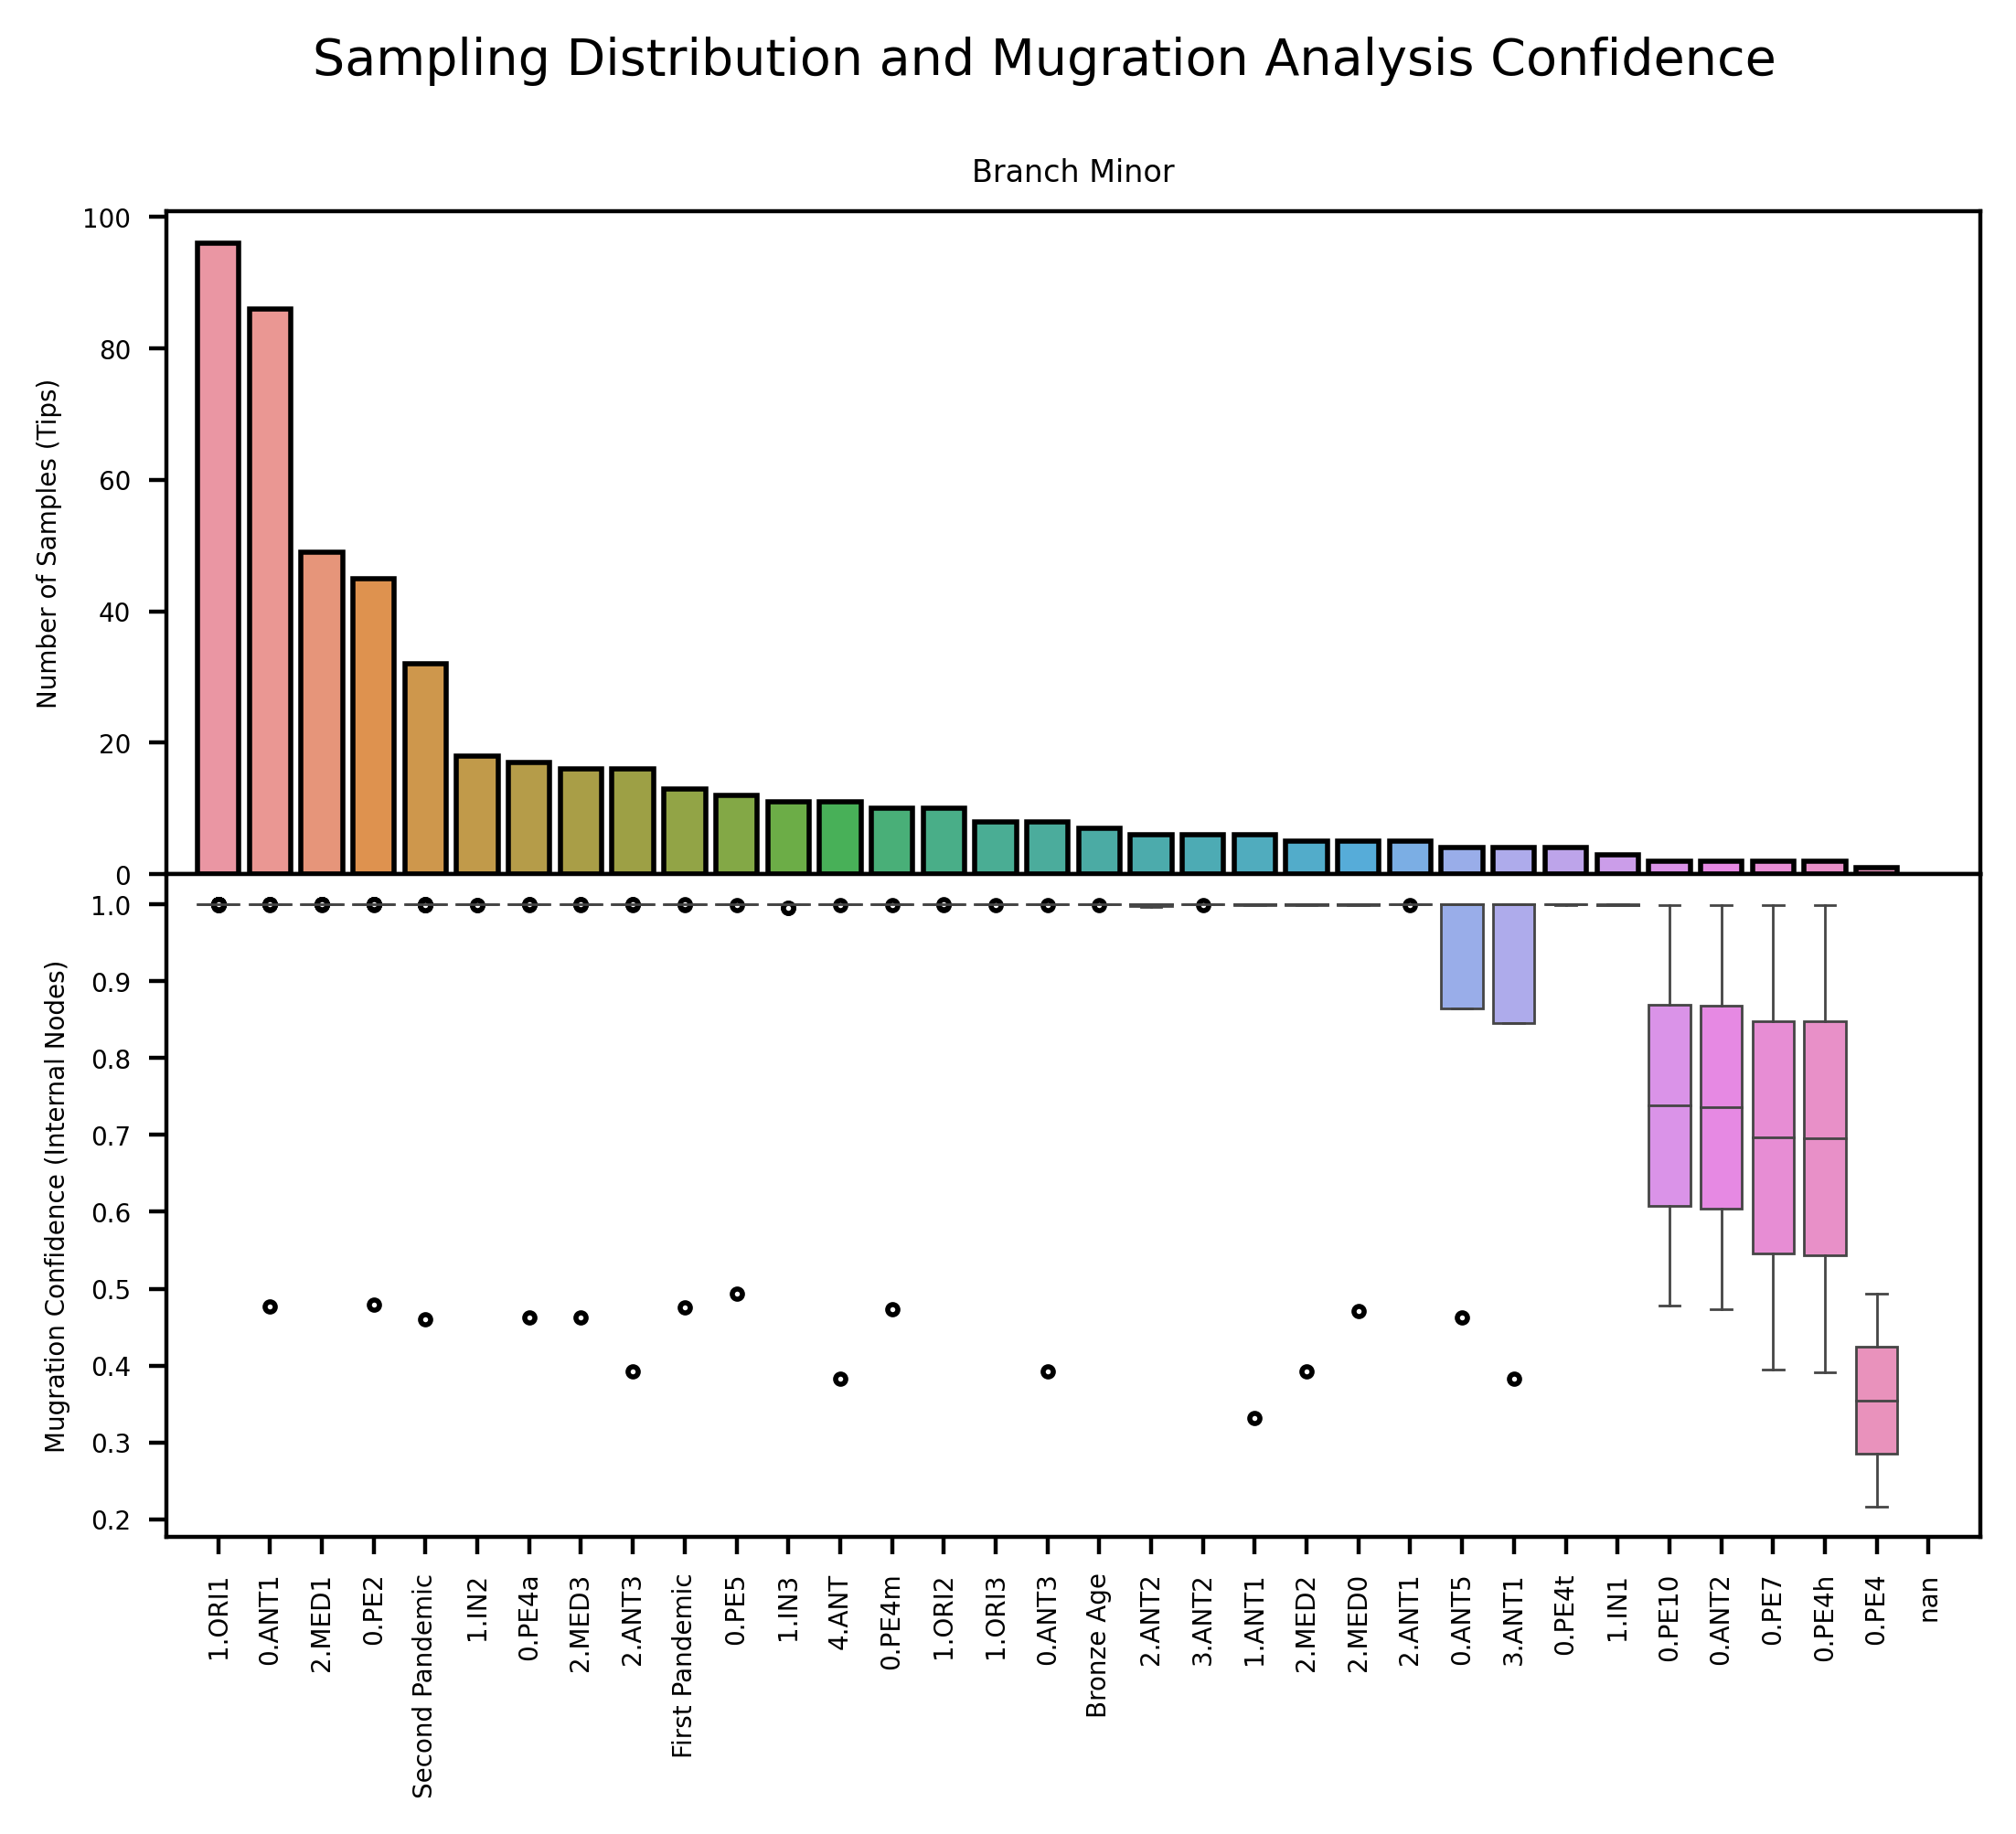

In [10]:
for attr in ATTRIBUTE_LIST:
    fig, (ax1, ax2) = plt.subplots(2, 
                               sharex=False, 
                               gridspec_kw={'hspace': 0},
                               figsize=figsize, 
                               dpi=dpi,
                               #constrained_layout=True,
                              )
    
    # --------------------------
    # Axis 1 - Number of tips per state
    # Exclude samples with no attribute recorded
    data = tree_df[tree_df[attr] != NO_DATA_CHAR]
    label_order = list(data[attr].value_counts().index)
    label_order = [lab for lab in label_order if lab != "nan"] + ["nan"]
    sns.countplot(data=data, 
                  x=attr, 
                  #color="blue", 
                  edgecolor="black",
                  ax=ax1, 
                  order=label_order)
    plt.setp(ax1.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(xticklabels, rotation = 90, ha="right")
    ax1.set_xlabel("")
    ax1.set_ylabel("Number of Samples (Tips)")
    ax1.set_xlim(-1,len(label_order)) 
    ax1.set_title(attr.replace("_"," "))
    
    # --------------------------
    # Axis 2 - Mugration Confidence
    # Exclude nodes that are terminals (ie. branch support is grey)
    data = tree_df[tree_df["Branch_Support_Color"] != "grey"]
    # Customize outlier style
    flierprops = dict(marker='o', markerfacecolor='white', markersize=2,
                      linestyle='none', markeredgecolor='black')
    # Create a boxplot
    sns.boxplot(data=data, 
                  x="Mugration_" + attr, 
                  y="Mugration_" + attr + "_Confidence",
                  #color="blue", 
                  ax=ax2, 
                  order=label_order,
                  flierprops=flierprops)
    #plt.setp(ax2.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax2.get_xticklabels()]
    ax2.set_xticklabels(xticklabels, rotation = 90, ha="center")
    #ax2.axhline(y=MUG_CONF_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
    ax2.set_xlabel("")
    ax2.set_ylabel("Mugration Confidence (Internal Nodes)")
    ax2.set_xlim(-1,len(label_order))
    
    fig.suptitle("Sampling Distribution and Mugration Analysis Confidence")
    
    out_path = os.path.join(outdir, "mug_boxplot_{}.jpg".format(attr.lower())) 
    plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

### Color branches on mugration tree according to state

In [11]:
for attr in ATTRIBUTE_LIST:
    tree_mug = mug_dict[attr]["tree_mug"].tree
    unique_states = mug_dict[attr]["unique_states"]
    
    # Deepest nodes first
    tree_mug.ladderize(reverse=False)

    # Initialize the states
    ordered_states = []
    
    # Get the ladderized order of attributes
    for t in tree_mug.get_terminals():
        for prop in t.other:
            if prop.namespace == attr + "_assign" and prop.tag not in ordered_states:
                ordered_states.append(prop.tag)
    
    # Number of states that need colors (exclude nan)
    num_attr = len(unique_states[:-1])
    print(num_attr)

    # Create the custom color map (pyplot)
    cmap = plt.get_cmap(COLOR_PAL,num_attr)
    cmaplist = [cmap(i) for i in range(cmap.N)]
    
    # Create the custom color map (seaborn)    
    #cmaplist = sns.color_palette("husl", num_attr)   
    # force the first color entry to be grey
    #num_attr = num_attr + 1

    # create the new map
    cmap = colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, num_attr)
    print(cmap)
    
    cmaplist = cmap(np.linspace(0, 1, num_attr))
    hex_list = [colors.to_hex(col) for col in cmaplist]

    hex_dict = {}

    # Assign states colors based on tip order (Low Conf first as grey)
    for state,hex_col in zip(ordered_states, hex_list):
        hex_dict[state] = hex_col

    # OPTIONAL: Add Low confidence grey to colormap
    hex_dict["Low Confidence"] = "grey"
    
    # START HERE
    # Add the hex color dict to the dict
    mug_dict[attr]["hex_color"] = hex_dict

    # Color branches by attr
    for c in tree_mug.find_clades():
        for prop in c.other:
            if prop.namespace == attr + "_assign":
                # Color by category
                c.color = hex_dict[prop.tag]
                # OPTIONAL: Color grey if low confidence
                if float(prop.value) < MUG_CONF_THRESH:
                    c.color = "grey"    
    print(hex_dict)

12
{'Bronze Age': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', 'First Pandemic': '#0cc1e8', 'Second Pandemic': '#3ae8d7', '3.ANT': '#68fcc1', '4.ANT': '#97fca7', '2.ANT': '#c5e88a', '2.MED': '#f3c16a', '1.ANT': '#ff8a48', '1.IN': '#ff4824', '1.ORI': '#ff0000', 'Low Confidence': 'grey'}
33
{'Bronze Age': '#8000ff', '0.PE7': '#7019ff', '0.PE2': '#6032fe', '0.PE4': '#504afc', '0.PE10': '#4062fa', '0.PE4m': '#3078f7', '0.PE4h': '#208ef4', '0.PE4t': '#10a2f0', '0.PE4a': '#00b4ec', '0.PE5': '#10c5e7', '0.ANT1': '#20d4e1', 'First Pandemic': '#30e1db', '0.ANT2': '#40ecd4', '0.ANT5': '#50f4cd', '0.ANT3': '#60fac5', 'Second Pandemic': '#70febd', '3.ANT1': '#80ffb4', '3.ANT2': '#8ffeab', '4.ANT': '#9ffaa2', '2.ANT2': '#aff498', '2.ANT1': '#bfec8e', '2.ANT3': '#cfe183', '2.MED0': '#dfd478', '2.MED3': '#efc56d', '2.MED2': '#ffb462', '2.MED1': '#ffa256', '1.ANT1': '#ff8e4a', '1.IN1': '#ff783e', '1.IN2': '#ff6232', '1.IN3': '#ff4a25', '1.ORI1': '#ff3219', '1.ORI3': '#ff190d', '1.ORI2': '#ff0000'

In [12]:
## alternate colors

### Plot colored mugration tree

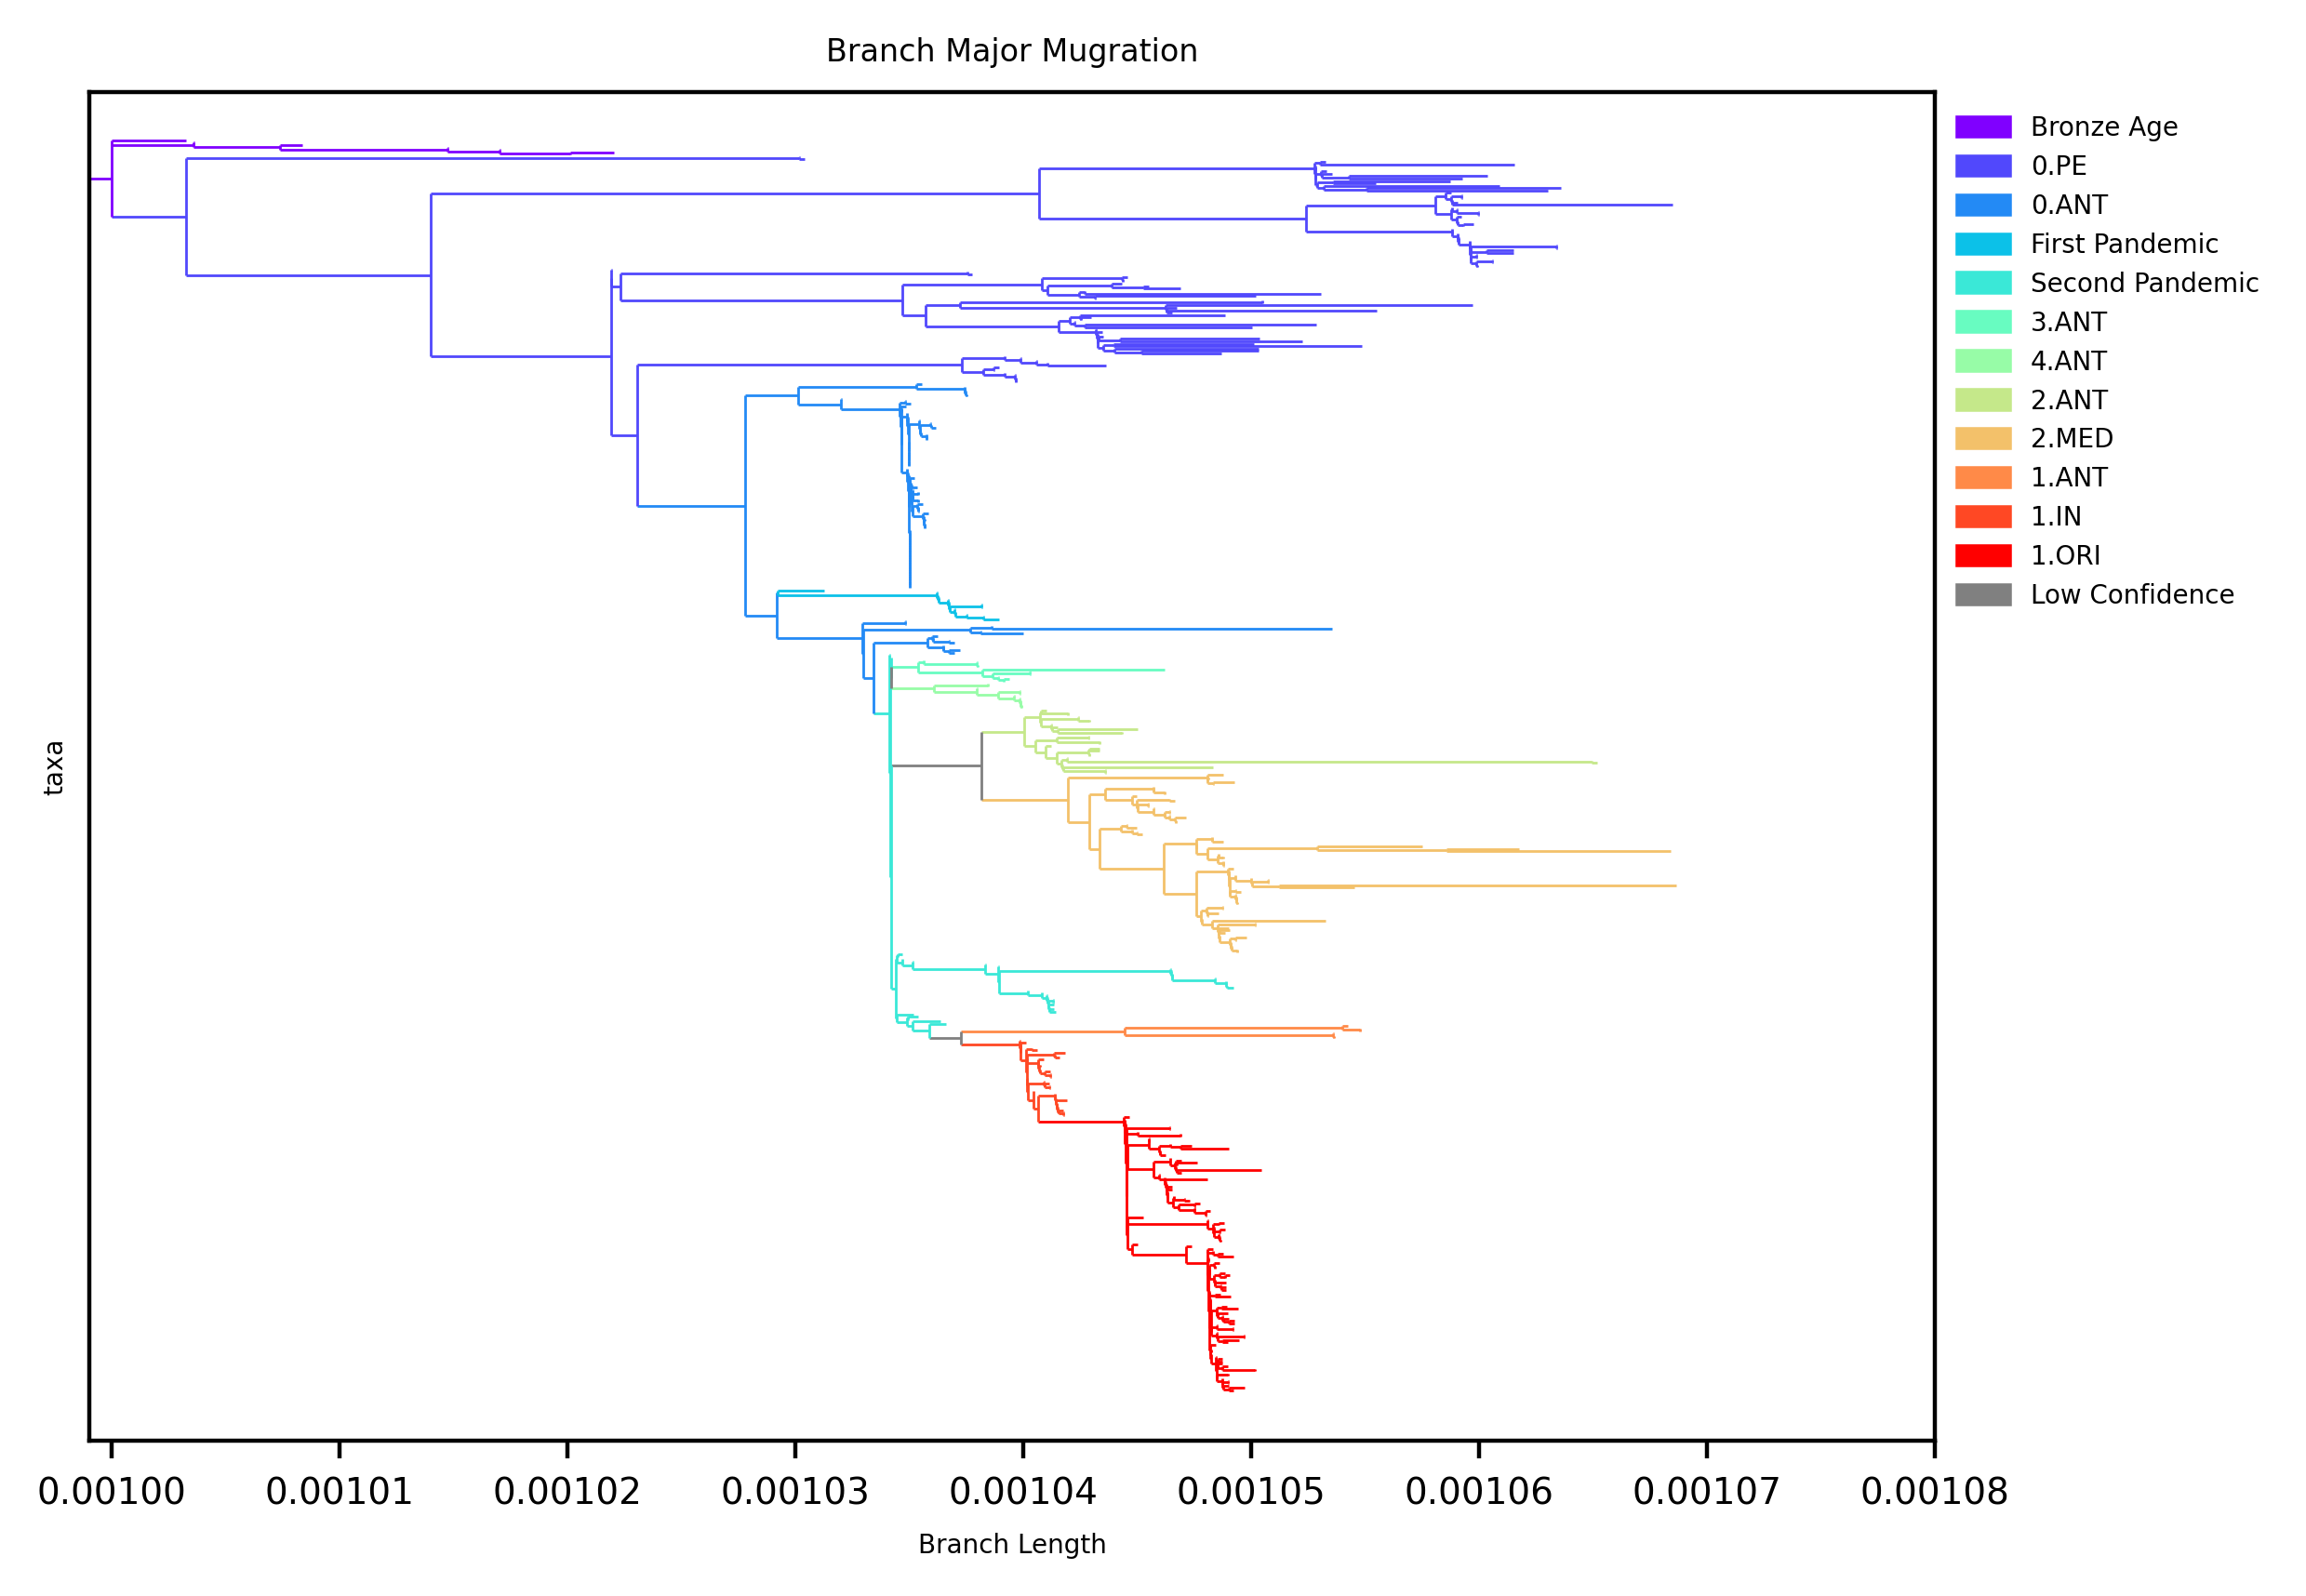

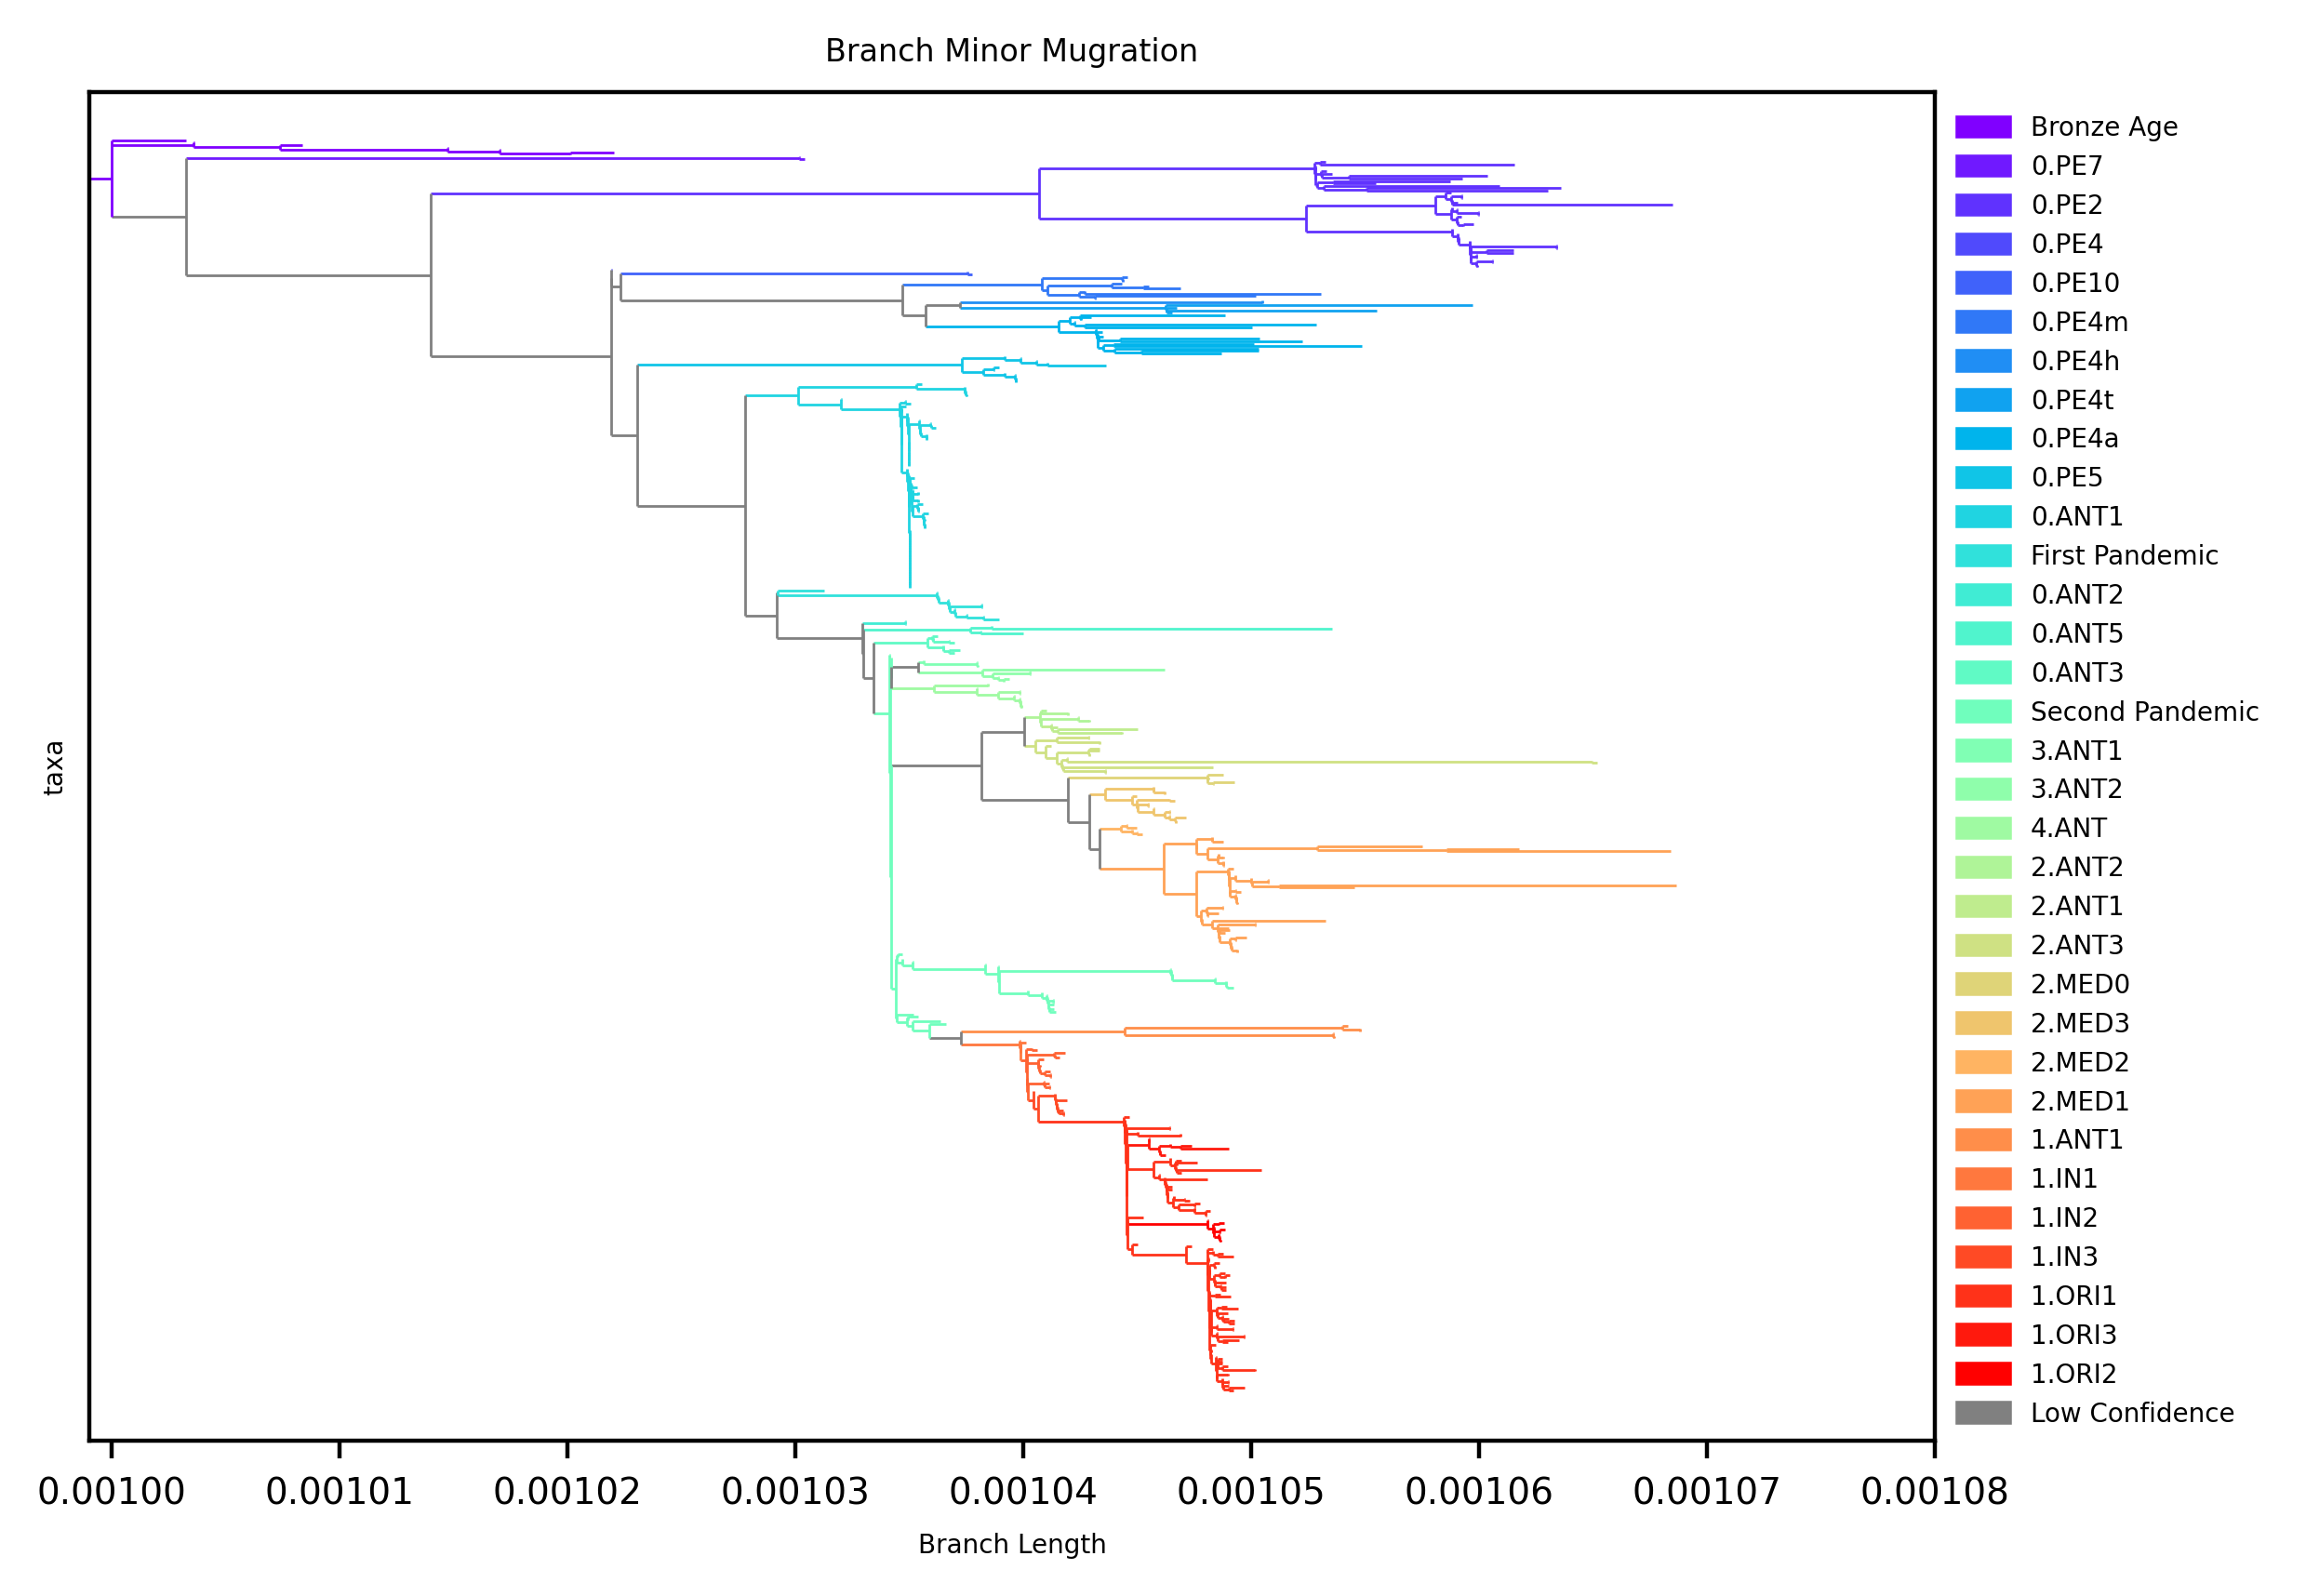

In [13]:
for attr in ATTRIBUTE_LIST:   
    mug_tree = mug_dict[attr]["tree_mug"].tree
    
    fig = plt.figure(dpi=dpi, figsize=figsize)
    ax = plt.subplot()

    # Deepest nodes first
    mug_tree.ladderize(reverse=True)


    # Draw tree to the canvas
    Phylo.draw(mug_tree, 
               axes=ax, 
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)

    # Root branch length set to 0.001
    # Ticks
    ax.set_xlim(0.000999,0.00108)
    ax.set_ylim(-20,len(mug_tree.get_terminals())+20)
    ax.set_yticks([])
    plt.xticks(fontsize=7)

    # Labels
    plt.xlabel("Branch Length")
    #plt.ylabel("Taxa")
    plt.title("{} Mugration".format(attr.replace("_"," ")))

    # Legend
    legend_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[attr]["hex_color"].values()]
    legend_labels = list(mug_dict[attr]["hex_color"].keys())

    ax.legend(legend_elements, 
              legend_labels,
              bbox_to_anchor=(1.0, 1.0), 
              loc='upper left',
              frameon=False,
             )

    # Write to file
    out_path = os.path.join(outdir, "mug_tree_{}.jpg".format(attr.lower()))  
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Questions

### 2. How much phylogeographic signal is present in the *Yersinia pestis* phylogeny?

In [14]:
"""# Store terminals in two lists for comparison
term_list = [t for t in tree_div.get_terminals()]
term_list.reverse()

dist_div_list = []
dist_geo_list = []

i = 0
progress_log_breaks = [num for num in range(0,101)]
i_progress = 0

for t1 in term_list:
    
    t1_name = t1.name
    t1_lat = tree_df[ATTRIBUTE_LAT][t1.name]
    t1_lon = tree_df[ATTRIBUTE_LON][t1.name]
    t1_latlon = (t1_lat, t1_lon)
    
    # Skip if natlon is nan
    if t1_lat == "NA" or t1_lon == "NA":
        continue
        
    # Iterate through terminals again for distance measures
    for t2 in term_list:           
        t2_name = t2.name     
        # Skip if it's a self comparison
        if t1_name == t2_name: continue
            
        t2_lat = tree_df[ATTRIBUTE_LAT][t2_name]
        t2_lon = tree_df[ATTRIBUTE_LON][t2_name]
        
        # Skip if latlon is nan
        if t2_lat == "NA" or t2_lon == "NA":
            continue
        t2_latlon = (t2_lat, t2_lon)
       
        # Calculate branch distance (divergence)
        dist_div = tree_div.distance(t1_name, t2_name)  
        # Calculate geographic distance (great circle)
        dist_geo = getattr(great_circle(t1_latlon, t2_latlon), DIST_UNIT)
        dist_div_list.append(dist_div)
        dist_geo_list.append(dist_geo)
    
    # Counter for a progress log since this is slow
    i+=1
    progress = (i / len(term_list)) * 100
    if progress >= progress_log_breaks[i_progress]:
        print("{:0.0f}%".format(progress))
        i_progress += 1
    #if i ==5:
    #    break"""

'# Store terminals in two lists for comparison\nterm_list = [t for t in tree_div.get_terminals()]\nterm_list.reverse()\n\ndist_div_list = []\ndist_geo_list = []\n\ni = 0\nprogress_log_breaks = [num for num in range(0,101)]\ni_progress = 0\n\nfor t1 in term_list:\n    \n    t1_name = t1.name\n    t1_lat = tree_df[ATTRIBUTE_LAT][t1.name]\n    t1_lon = tree_df[ATTRIBUTE_LON][t1.name]\n    t1_latlon = (t1_lat, t1_lon)\n    \n    # Skip if natlon is nan\n    if t1_lat == "NA" or t1_lon == "NA":\n        continue\n        \n    # Iterate through terminals again for distance measures\n    for t2 in term_list:           \n        t2_name = t2.name     \n        # Skip if it\'s a self comparison\n        if t1_name == t2_name: continue\n            \n        t2_lat = tree_df[ATTRIBUTE_LAT][t2_name]\n        t2_lon = tree_df[ATTRIBUTE_LON][t2_name]\n        \n        # Skip if latlon is nan\n        if t2_lat == "NA" or t2_lon == "NA":\n            continue\n        t2_latlon = (t2_lat, t2_lon)\

In [15]:
"""
# Create a joint plot

g = sns.JointGrid()
g.fig.set_dpi(dpi)

# Main Scatter
#sns.regplot(
sns.scatterplot(
                x=dist_div_list,
                y=dist_geo_list,  
                s=1,
                #scatter_kws = {"s": 0.5}, 
                ax=g.ax_joint,
                #line_kws={"color": "red"}
               )

sns.kdeplot(x=dist_div_list, 
            linewidth=1,
            fill=True,
            ax=g.ax_marg_x,
            #bw_method=0.03,
           )

sns.kdeplot(y=dist_geo_list, 
            linewidth=1,
            fill=True,
            ax=g.ax_marg_y,
            bw_method=0.03,
           )

# Constrain view and limits
g.ax_marg_y.set_ylim(0-500,int(max(dist_geo_list)) + 500)

# Labels and Titles
g.ax_joint.set_xlabel("Genetic Distance (Branch Length)")
g.ax_joint.set_ylabel("Geographic Distance (km)")
g.fig.suptitle("Phylogeographic Signal as Isolation by Distance",
                x=0.5,
                y=1.05)

# Caption
caption_text = ("Pairwise genetic distance (branch length) compared with pariwise geographic distance (greater circle)." 
                + "\nGeographic Resolution: {}".format(ATTRIBUTE)
               )
g.fig.text(0.4, -0.05, caption_text, ha='center')

# Save
out_path = os.path.join(outdir, "treetime_{}_IBD.jpg".format(ATTRIBUTE.lower())) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")"""

'\n# Create a joint plot\n\ng = sns.JointGrid()\ng.fig.set_dpi(dpi)\n\n# Main Scatter\n#sns.regplot(\nsns.scatterplot(\n                x=dist_div_list,\n                y=dist_geo_list,  \n                s=1,\n                #scatter_kws = {"s": 0.5}, \n                ax=g.ax_joint,\n                #line_kws={"color": "red"}\n               )\n\nsns.kdeplot(x=dist_div_list, \n            linewidth=1,\n            fill=True,\n            ax=g.ax_marg_x,\n            #bw_method=0.03,\n           )\n\nsns.kdeplot(y=dist_geo_list, \n            linewidth=1,\n            fill=True,\n            ax=g.ax_marg_y,\n            bw_method=0.03,\n           )\n\n# Constrain view and limits\ng.ax_marg_y.set_ylim(0-500,int(max(dist_geo_list)) + 500)\n\n# Labels and Titles\ng.ax_joint.set_xlabel("Genetic Distance (Branch Length)")\ng.ax_joint.set_ylabel("Geographic Distance (km)")\ng.fig.suptitle("Phylogeographic Signal as Isolation by Distance",\n                x=0.5,\n                y=1.05)\

## Color Palettes

In [16]:
num_attr = 11

In [17]:
sns.color_palette("husl", 12)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20312757197899856, 0.6881249249803418, 0.5177618167447304),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21786710662428366, 0.6656671601322255, 0.7482809385065813),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9633321742064956, 0.40643825645731757, 0.7592537599568671)]

In [18]:
sns.color_palette("flare", 
                  num_attr, 
                  #as_cmap=True
                 )

[(0.92198615, 0.60943622, 0.45509686),
 (0.91262605, 0.52893336, 0.40749715),
 (0.89737819, 0.44322747, 0.37043052),
 (0.87199254, 0.3633634, 0.35974223),
 (0.82754694, 0.29677989, 0.37712733),
 (0.75861834, 0.25356035, 0.40663694),
 (0.68113541, 0.23115942, 0.42717615),
 (0.60407977, 0.21017746, 0.43913439),
 (0.52386353, 0.18939409, 0.44182449),
 (0.44584668, 0.17360625, 0.43114133),
 (0.36833779, 0.15813871, 0.40911916)]

In [19]:
sns.color_palette("ch:s=.25,rot=-.25", 
                  num_attr,
                  #as_cmap=True,
                 )

[(0.7801075672866592, 0.8741945391838343, 0.9197573835143084),
 (0.693674456112547, 0.8052360472399624, 0.8836411417430744),
 (0.6177504996551004, 0.7314502499602763, 0.8447555651263752),
 (0.5510466640385299, 0.6539573922318259, 0.8006075874410353),
 (0.4918432062949203, 0.5740168020110973, 0.7491328109279964),
 (0.44094736837293363, 0.4974844322442154, 0.6923710472717917),
 (0.39013304226733464, 0.4166783742582536, 0.622658850746535),
 (0.3399990014728763, 0.3374528038960161, 0.5426141164337496),
 (0.28792523273618836, 0.2611133597120989, 0.4523793400369642),
 (0.23129851590545927, 0.18884892919992666, 0.3527047044456967),
 (0.1676124288206785, 0.12168378009569247, 0.24493209028077442)]

In [20]:
sns.color_palette("rocket",
                 num_attr,
                 )

[(0.12375803, 0.07174938, 0.18228425),
 (0.24525608, 0.10497384, 0.26395596),
 (0.38092887, 0.12061482, 0.32506528),
 (0.51728314, 0.1179558, 0.35453252),
 (0.65824241, 0.09552918, 0.3536529),
 (0.7965014, 0.10506637, 0.31063031),
 (0.89490337, 0.21785614, 0.25314362),
 (0.94291042, 0.37549479, 0.26369821),
 (0.95922872, 0.53307513, 0.3748895),
 (0.96443322, 0.67025402, 0.51509334),
 (0.96893132, 0.79809112, 0.68512266)]

In [21]:
sns.color_palette("Spectral", num_attr)

[(0.7972318339100346, 0.20092272202998845, 0.3008073817762399),
 (0.9139561707035756, 0.36239907727797, 0.27935409457900806),
 (0.9748558246828143, 0.5574009996155325, 0.32272202998846594),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9966935793925413, 0.8975009611687812, 0.5770857362552863),
 (0.998077662437524, 0.9992310649750096, 0.7460207612456747),
 (0.9173394848135333, 0.9669357939254134, 0.6200692041522493),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.5273356401384084, 0.8106113033448674, 0.6452133794694349),
 (0.3280276816608997, 0.6805074971164936, 0.6802768166089965),
 (0.2265282583621684, 0.4938869665513264, 0.7224913494809688)]

## Saving

In [22]:
# Save tree dataframe with mugration info
out_path = os.path.join(outdir, "mugration.tsv" )
tree_df.to_csv(out_path, sep="\t")

## Cleanup

In [23]:
os.remove(tmp_xml)

NameError: name 'tmp_xml' is not defined